<a href="https://colab.research.google.com/github/NewCodeLearner/HandsOnLLM-Projects/blob/main/13_Creating_Text_Embedding_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating Text Embedding Model
Exploring methods for both training and fine-tuning embedding models.

We will want to use a GPU to run the examples in this notebook. In Google Colab, go to Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4.

In [ ]:
%%capture
!pip install -q accelerate>=0.27.2 peft>=0.9.0 bitsandbytes>=0.43.0 transformers>=4.38.2 trl>=0.7.11 sentencepiece>=0.1.99
!pip install -q sentence-transformers>=3.0.0 mteb>=1.1.2 datasets>=2.18.0

# Creating an Embedding Model

## Data

Dataset link from huggingface : https://huggingface.co/datasets/nyu-mll/glue

In [ ]:
from datasets import load_dataset

# Load MNLI dataset from GLUE
# 0 = entailment, 1 = neutral, 2 = contradiction
train_dataset = load_dataset("glue", "mnli", split="train").select(range(50_000))
train_dataset = train_dataset.remove_columns("idx")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [ ]:
train_dataset[2]

{'premise': 'One of our number will carry out your instructions minutely.',
 'hypothesis': 'A member of my team will execute your orders with immense precision.',
 'label': 0}

## Model

In [ ]:
from sentence_transformers import SentenceTransformer

# Use a base model
embedding_model = SentenceTransformer('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Loss Function

In [ ]:
from sentence_transformers import losses

# Define the loss function. In soft-max loss, we will also need to explicitly set the number of labels.
train_loss = losses.SoftmaxLoss(
    model=embedding_model,
    sentence_embedding_dimension=embedding_model.get_sentence_embedding_dimension(),
    num_labels=3
)

## Evaluation

In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# Create an embedding similarity evaluator for stsb
val_sts = load_dataset('glue', 'stsb', split='validation')
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_sts["sentence1"],
    sentences2=val_sts["sentence2"],
    scores=[score/5 for score in val_sts["label"]],
    main_similarity="cosine",
)

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

## Training

In [ ]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

# Define the training arguments
args = SentenceTransformerTrainingArguments(
    output_dir="base_embedding_model",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=100,
)

In [ ]:
from sentence_transformers.trainer import SentenceTransformerTrainer

# Train embedding model
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=train_dataset,
    loss=train_loss,
    evaluator=evaluator
)
trainer.train()

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: girish-barhate (girish-barhate-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


dataset = dataset.select_columns(['hypothesis', 'entailment', 'contradiction'])


Step,Training Loss
100,1.070300
200,0.933400
300,0.881000
400,0.836300
500,0.820600
600,0.830200
700,0.811400
800,0.793300
900,0.774300
1000,0.767900


TrainOutput(global_step=1563, training_loss=0.812378203037528, metrics={'train_runtime': 380.8837, 'train_samples_per_second': 131.274, 'train_steps_per_second': 4.104, 'total_flos': 0.0, 'train_loss': 0.812378203037528, 'epoch': 1.0})

## Weights and Biases training report

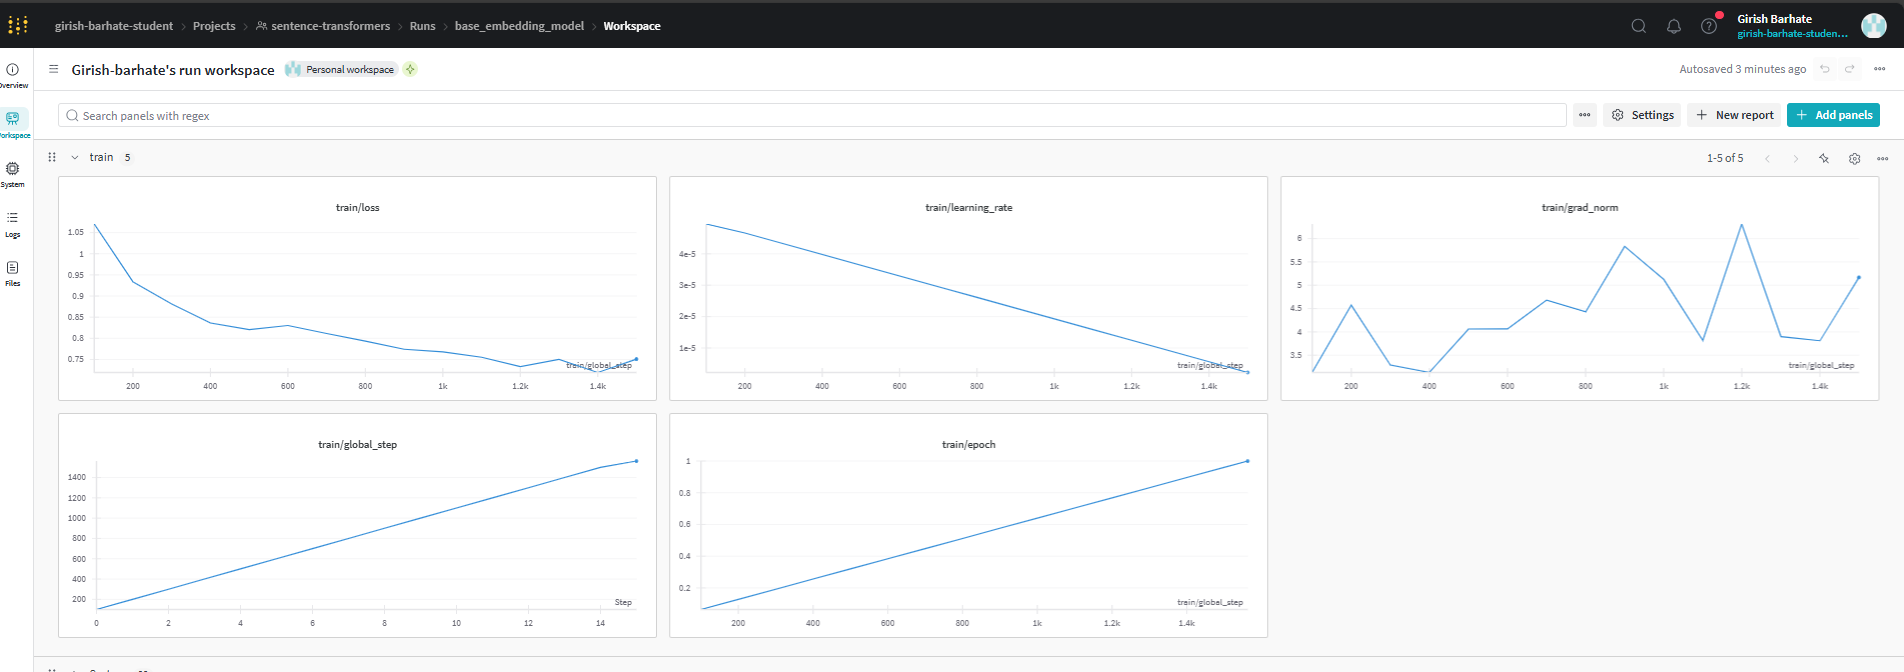

# MTEB

In [ ]:
from mteb import MTEB

# Choose evaluation task
evaluation = MTEB(tasks=["Banking77Classification"])

# Calculate results
results = evaluation.run(embedding_model)
results

VRAM Clean-up - You will need to run the code below to partially empty the VRAM (GPU RAM). If that does not work, it is advised to restart the notebook instead. You can check the resources on the right-hand side (if you are using Google Colab) to check whether the used VRAM is indeed low. You can also run !nivia-smi to check current usage.

In [ ]:
# # Empty and delete trainer/model
# trainer.accelerator.clear()
# del trainer, embedding_model

# # Garbage collection and empty cache
# import gc
# import torch

# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

## Loss Fuctions